Saving Einstein_ledeNew.jpg to Einstein_ledeNew (7).jpg


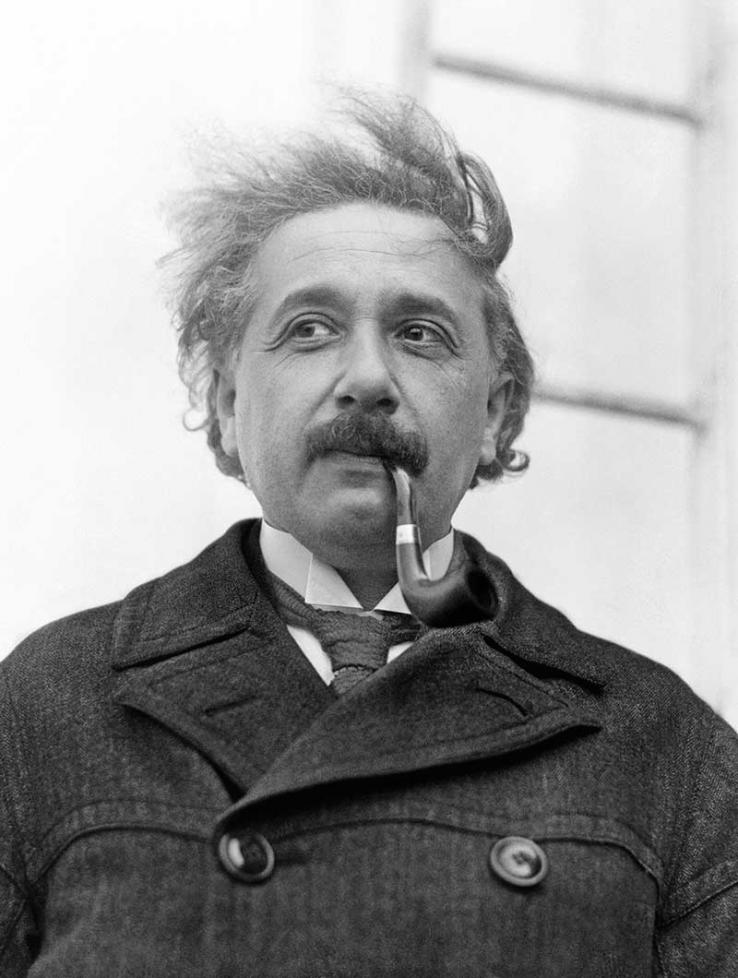

ValueError: ignored

<PIL.Image.Image image mode=F size=738x978>

In [ ]:
# Import necessary libraries
from google.colab import files
from io import BytesIO
from PIL import Image
import numpy as np
import random

def noise(image, salt_prob, pepper_prob, g=False):
    img_array = np.array(image)


    mean=0
    sigma=25
    noise = np.random.normal(mean, sigma, img_array.shape)

      # Add the Gaussian noise to the image
    noisy_img_array = img_array + noise
    noisy_img_array = np.clip(noisy_img_array, 0, 255)

      # Convert back to PIL image
      # noisy_image = Image.fromarray(noisy_img_array.astype(np.uint8))
    noisy_image = Image.fromarray(noisy_img_array)
    img_array = np.array(noisy_image)
    #img_array = np.array(noisy_img_array)

    for i in range(img_array.shape[0]):
        for j in range(img_array.shape[1]):
            random_number = random.random()
            if random_number < salt_prob:
                img_array[i][j] = 255
            elif random_number > 1 - pepper_prob:
                img_array[i][j] = 0

    noisy_image = Image.fromarray(img_array)
    return noisy_image

# Upload image
uploaded = files.upload()
if not uploaded:
    print("File not uploaded.")
else:
    for fn in uploaded.keys():
        # Open the image
        image = Image.open(BytesIO(uploaded[fn]))

        # Convert to grayscale
        image = image.convert('L')

        noisy_image = noise(image, salt_prob=0.05, pepper_prob=0.05, g=True)

        # Display the original and noisy image
        display(image, noisy_image)


In [ ]:
def apply_laplacian_filter(image):
    kernel = np.array([[0, -1, 0],
                       [-1, 4, -1],
                       [0, -1, 0]])
    result = np.zeros(image.shape)
    padded_image = np.pad(image, [(1, 1), (1, 1), (0, 0)], mode='edge')

    for i in range(image.shape[0]):
        for j in range(image.shape[1]):
            for k in range(image.shape[2]):
                result[i, j, k] = np.sum(kernel * padded_image[i:i+3, j:j+3, k])

    return result

def sharpen_image(original, laplacian):
    sharpened = np.clip(original + laplacian, 0, 255).astype(np.uint8)
    return sharpened


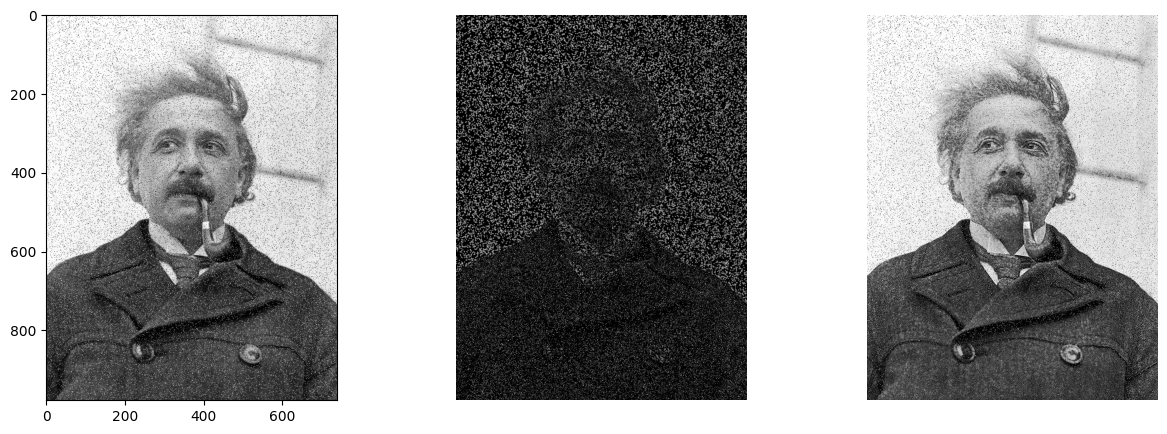

In [ ]:
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

if noisy_image.mode == 'L':
    # Convert it to a 3-channel image by duplicating the grayscale channel
    noisy_image = noisy_image.convert('RGB')
noisy_image_np = np.array(noisy_image)

if len(noisy_image_np.shape) == 2 or (noisy_image_np.shape[2] == 1):
    noisy_image_np = np.stack((noisy_image_np,) * 3, axis=-1)

laplacian_image = apply_laplacian_filter(noisy_image_np)
sharpened_image = sharpen_image(noisy_image_np, laplacian_image)


plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
plt.imshow(np.clip(noisy_image, 0, 255).astype(np.uint8), cmap='gray')

plt.subplot(1, 3, 2)
plt.imshow(np.clip(laplacian_image, 0, 255).astype(np.uint8))
plt.axis('off')
plt.subplot(1, 3, 3)
plt.imshow(sharpened_image)
plt.axis('off')
plt.show()

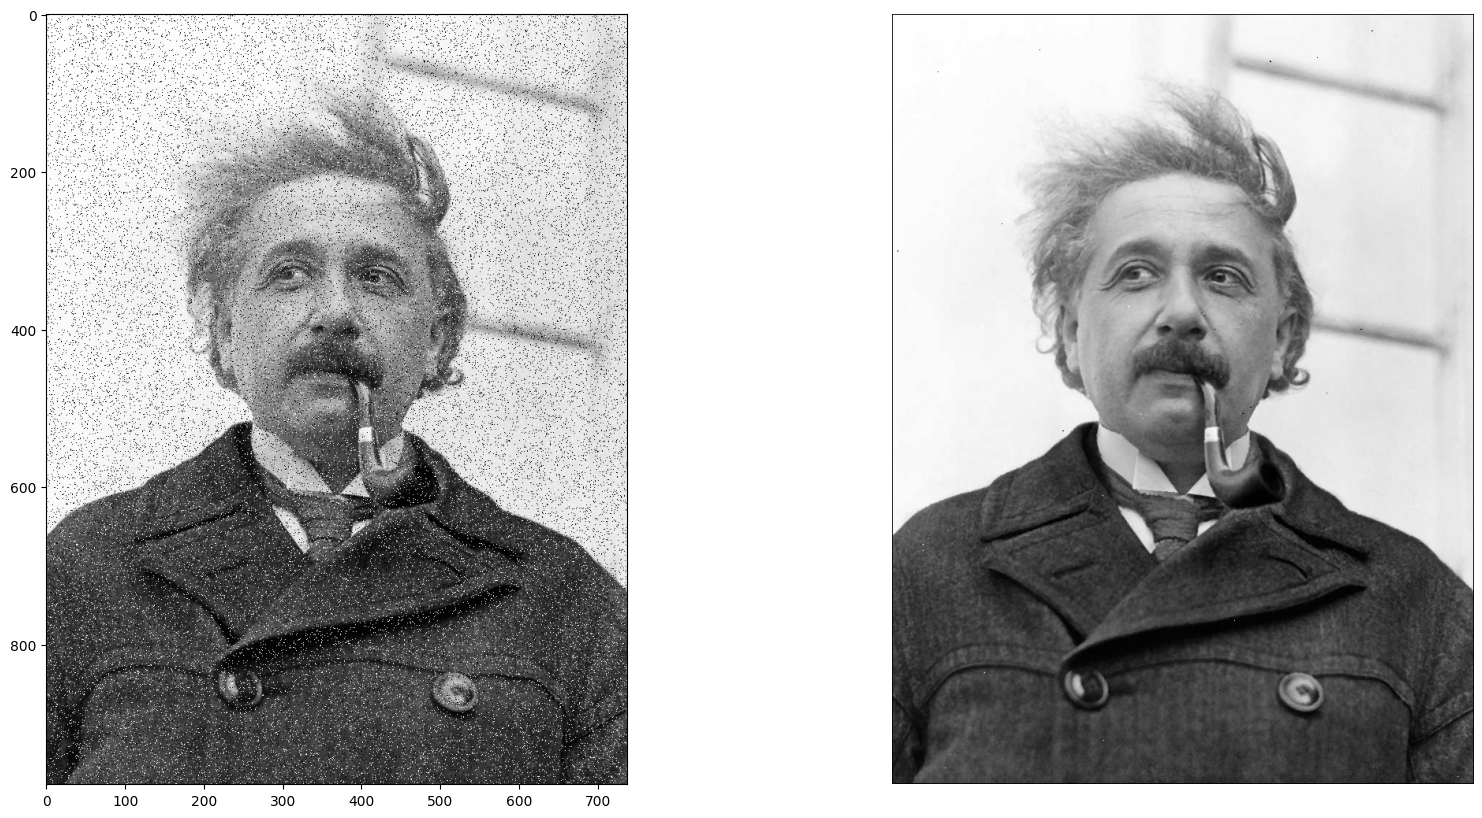

In [ ]:
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

def median_filter(input_image, kernel_size):
    img_array = np.array(input_image)
    output_array = np.zeros(img_array.shape)
    margin = kernel_size // 2

    for i in range(margin, img_array.shape[0] - margin):
        for j in range(margin, img_array.shape[1] - margin):
            neighborhood = img_array[i - margin:i + margin + 1, j - margin:j + margin + 1]
            median_value = np.median(neighborhood)
            output_array[i, j] = median_value
    output_image = Image.fromarray(output_array.astype('uint8'))
    return output_image

# Assuming noisy_image is already a PIL.Image object and is in grayscale
filtered_image = median_filter(noisy_image, kernel_size=3)


plt.figure(figsize=(20, 10))
plt.subplot(1, 2, 1)
plt.imshow(np.clip(noisy_image, 0, 255).astype(np.uint8), cmap='gray')

plt.subplot(1, 2, 2)
plt.imshow(np.clip(filtered_image, 0, 255).astype(np.uint8))

plt.axis('off')
plt.show()

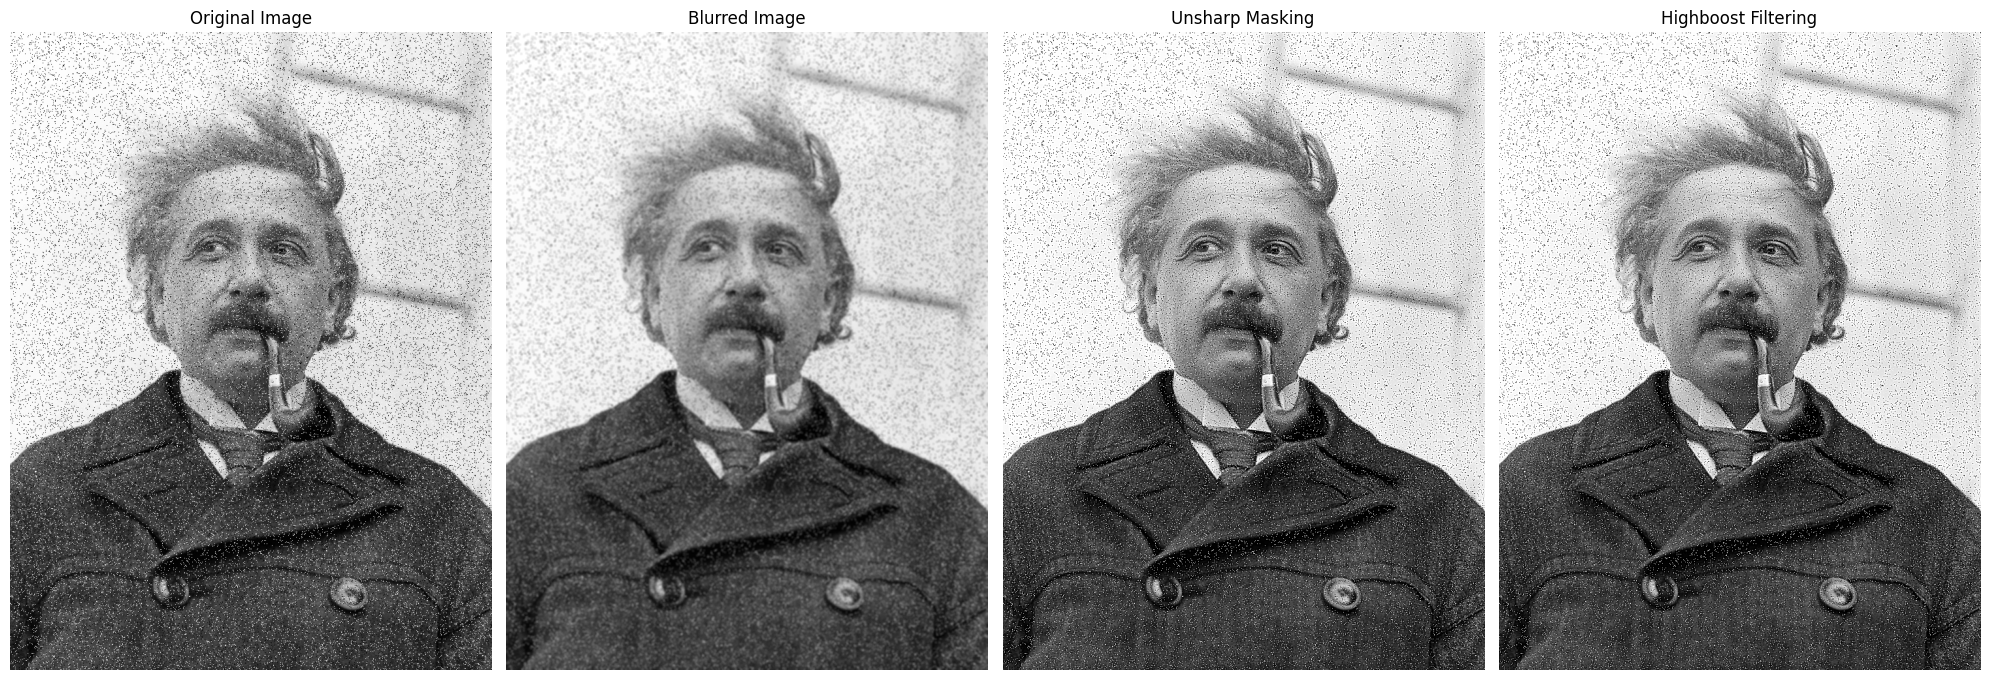

In [ ]:
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from google.colab import files
import cv2

def gaussian_kernel(size, sigma):
    """Create a Gaussian kernel given a size and sigma."""
    ax = np.linspace(-(size - 1) / 2., (size - 1) / 2., size)
    xx, yy = np.meshgrid(ax, ax)
    kernel = np.exp(-0.5 * (np.square(xx) + np.square(yy)) / np.square(sigma))
    kernel = kernel / (2*3.14*np.square(sigma))

    # Normalizes the generated kernel by dividing all its values by the sum of all values in the kernel. This ensures that the sum of the kernel values is 1,for better brightness
    return kernel / np.sum(kernel)

def apply_filter(image_array, kernel):
    height, width = image_array.shape
    kernel_height, kernel_width = kernel.shape
    pad_height, pad_width = kernel_height // 2, kernel_width // 2
    padded_image = np.pad(image_array, ((pad_height, pad_height), (pad_width, pad_width)), mode='reflect')
    new_image = np.zeros(image_array.shape)

    for i in range(height):
        for j in range(width):
            new_image[i, j] = np.sum(kernel * padded_image[i:i+kernel_height, j:j+kernel_width])
    return new_image

def unsharp_masking_and_highboost_filtering(image_array, kernel_size=5, sigma=1.5, alpha=1):
    """Perform unsharp masking and highboost filtering on an image array."""
    # Create Gaussian blur kernel
    kernel = gaussian_kernel(kernel_size, sigma)

    # Apply Gaussian blur to the image
    blurred_array = apply_filter(image_array, kernel)

    # Create the mask
    mask = image_array - blurred_array

    # Unsharp masking
    sharpened_array = image_array + mask

    # Highboost filtering
    highboost_array = image_array + alpha * mask

    # Normalize the results
    sharpened_array = np.clip(sharpened_array, 0, 255)
    highboost_array = np.clip(highboost_array, 0, 255)

    return blurred_array, sharpened_array, highboost_array

# Convert the image to grayscale if it's a color image
if len(noisy_image_np.shape) == 3:
    noisy_image_np = cv2.cvtColor(noisy_image_np, cv2.COLOR_BGR2GRAY)


# Load the image and convert to grayscale
original_array = np.array(noisy_image, dtype=np.float32)

# Perform unsharp masking and highboost filtering
blurred_array, sharpened_array, highboost_array = unsharp_masking_and_highboost_filtering(noisy_image_np)

# Convert arrays back to images
blurred_image = Image.fromarray(blurred_array.astype(np.uint8))
sharpened_image = Image.fromarray(sharpened_array.astype(np.uint8))
highboost_image = Image.fromarray(highboost_array.astype(np.uint8))


# Plot and show the images
plt.figure(figsize=(20, 10))
plt.subplot(1, 4, 1)
plt.imshow(noisy_image, cmap='gray')
plt.title('Original Image')
plt.axis('off')

plt.subplot(1, 4, 2)
plt.imshow(blurred_image, cmap='gray')
plt.title('Blurred Image')
plt.axis('off')

plt.subplot(1, 4, 3)
plt.imshow(sharpened_image, cmap='gray')
plt.title('Unsharp Masking')
plt.axis('off')

plt.subplot(1, 4, 4)
plt.imshow(highboost_image, cmap='gray')
plt.title('Highboost Filtering')
plt.axis('off')

plt.tight_layout()
plt.show()

